# Keypoints

- Be careful of overflow like big number minus big number

- To prevent underflow, try staying in the log space

- Always using numerical libraries to prevent overflow

# Scalars

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Integers

### Binary representation of integers

In [3]:
format(16, '032b')

'00000000000000000000000000010000'

### Bit shifting

In [4]:
format(16 >> 2, '032b')

'00000000000000000000000000000100'

In [5]:
16 >> 2

4

In [6]:
format(16 << 2, '032b')

'00000000000000000000000001000000'

In [7]:
16 << 2

64

### Overflow

In general, the computer representation of integers has a limited range, and may overflow. The range depends on whether the integer is signed or unsigned.

For example, with 8 bits, we can represent at most $2^8 = 256$ integers.

- 0 to 255 unsigned
- -128 ti 127 signed

Signed integers

In [8]:
np.arange(130, dtype=np.int8)[-5:]

array([ 125,  126,  127, -128, -127], dtype=int8)

Unsigned integers

In [9]:
np.arange(130, dtype=np.uint8)[-5:]

array([125, 126, 127, 128, 129], dtype=uint8)

In [10]:
np.arange(260, dtype=np.uint8)[-5:]

array([255,   0,   1,   2,   3], dtype=uint8)

### Integer division

In Python 2 or other languages such as C/C++, be very careful when dividing as the division operator `/` performs integer division when both numerator and denominator are integers. This is rarely what you want. In Python 3 the `/` always performs floating point division, and you use `//` for integer division, removing a common source of bugs in numerical calculations.

In [11]:
%%python2

import numpy as np

x = np.arange(10)
print(x/10)

Couldn't find program: 'python2'


Python 3 does the "right" thing.

In [12]:
x = np.arange(10)
x/10

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

## Real numbers

Real numbers are represented as **floating point** numbers. A floating point number is stored in 3 pieces (sign bit, exponent, mantissa) so that every float is represetned as get +/- mantissa ^ exponent. Because of this, the interval between consecutive numbers is smallest (high precison) for numebrs close to 0 and largest for numbers close to the lower and upper bounds.

Because exponents have to be singed to represent both small and large numbers, but it is more convenint to use unsigned numbers here, the exponnent has an offset (also knwnn as the exponentn bias). For example, if the expoennt is an unsigned 8-bit number, it can rerpesent the range (0, 255). By using an offset of 128, it will now represent the range (-127, 128).

![float1](http://www.dspguide.com/graphics/F_4_2.gif)

**Note**: Intervals between consecutive floating point numbers are not constant. In particular, the precision for small numbers is much larger than for large numbers. In fact, approximately half of all floating point numbers lie between -1 and 1 when using the `double` type in C/C++ (also the default for `numpy`).

![float2](http://jasss.soc.surrey.ac.uk/9/4/4/fig1.jpg)

Because of this, if you are adding many numbers, it is more accurate to first add the small numbers before the large numbers.

#### IEEE 754 32-bit floating point representation

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Float_example.svg/590px-Float_example.svg.png)

See [Wikipedia](https://en.wikipedia.org/wiki/Single-precision_floating-point_format) for how this binary number is evaluated to 0.15625.

In [13]:
from ctypes import c_int, c_float

In [14]:
s = c_int.from_buffer(c_float(0.15625)).value

In [15]:
s = format(s, '032b')
s

'00111110001000000000000000000000'

In [16]:
rep = {
    'sign': s[:1], 
    'exponent' : s[1:9:], 
    'fraction' : s[9:]
}
rep

{'sign': '0', 'exponent': '01111100', 'fraction': '01000000000000000000000'}

### Most base 10 real numbers are approximations

This is simply because numbers are stored in finite-precision binary format.

In [17]:
'%.20f' % (0.1 * 0.1 * 100)

'1.00000000000000022204'

### Never check for equality of floating point numbers

In [18]:
i = 0
loops = 0
while i != 1:
    i += 0.1 * 0.1
    loops += 1
    if loops == 1000000:
        break
i

10000.000000171856

In [19]:
i = 0
loops = 0
while np.abs(1 - i) > 1e-6:
    i += 0.1 * 0.1
    loops += 1
    if loops == 1000000:
        break
i

1.0000000000000007

### Associative law does not necessarily hold

In [20]:
6.022e23 - 6.022e23 + 1

1.0

In [21]:
1 + 6.022e23 - 6.022e23

0.0

### Distributive law does not hold

In [22]:
a = np.exp(1)
b = np.pi
c = np.sin(1)

In [23]:
a*(b+c)

10.82708950985241

In [24]:
a*b + a*c

10.827089509852408

### Catastrophic cancellation

Consider calculating sample variance

$$
s^2= \frac{1}{n(n-1)}\sum_{i=1}^n x_i^2 - (\sum_{i=1}^n x_i)^2
$$

Be  careful whenever you calculate the difference of potentially big numbers.

In [13]:
def var(x):
    """Returns variance of sample data using sum of squares formula."""
    
    n = len(x)
    return (1.0/(n*(n-1))*(n*np.sum(x**2) - (np.sum(x))**2))

### Underflow

In [14]:
np.warnings.filterwarnings('ignore')

In [15]:
np.random.seed(4)
xs = np.random.random(1000)
ys = np.random.random(1000)
np.prod(xs)/np.prod(ys)

nan

#### Prevent underflow by staying in log space

In [28]:
x = np.sum(np.log(xs))
y = np.sum(np.log(ys))
np.exp(x - y)

696432868222.2549

### Overflow

In [29]:
np.exp(1000)

inf

### Numerically stable algorithms

#### What is the sample variance for numbers from a normal distribution with variance 1?

In [17]:
np.random.seed(15)
x_ = np.random.normal(0, 1, int(1e6))
x = 1e12 + x_
var(x)

-1328166901.4739892

#### Use functions from numerical libraries where available

In [18]:
np.var(x)

1.001345504504934

There is also a variance function in the standard library, but it is slower for large arrays.

In [19]:
import statistics

statistics.variance(x)

1.0013464175061981

Note that `numpy` uses does not use the asymptotically unbiased estimator by default. If you want the unbiased variance, set `ddof` to 1.

In [33]:
np.var([1,2,3,4], ddof=1)

1.6666666666666667

In [34]:
statistics.variance([1,2,3,4])

1.6666666666666667

### Useful numerically stable functions 

Let's calculate

$$
\log(e^{1000} + e^{1000})
$$

Using basic algebra, we get the solution $\log(2) + 1000$.

\begin{align}
\log(e^{1000} + e^{1000}) &= \log(e^{0}e^{1000} + e^{0}e^{1000}) \\
&= \log(e^{100}(e^{0} + e^{0})) \\
&= \log(e^{1000}) + \log(e^{0} + e^{0}) \\
&= 1000 + \log(2)
\end{align}

**logaddexp**

In [35]:
x = np.array([1000, 1000])
np.log(np.sum(np.exp(x)))

inf

In [36]:
np.logaddexp(*x)

1000.6931471805599

**logsumexp**

This function generalizes `logaddexp` to an arbitrary number of addends and is useful in a variety of statistical contexts.

Suppose we need to calculate a probability distribution $\pi$ parameterized by a vector $x$

$$
\pi_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}
$$

Taking logs, we get

$$
\log(\pi_i) = x_i - \log{\sum_{j=1}^n e^{x_j}}
$$

In [37]:
x = 1e6*np.random.random(100)

In [38]:
np.log(np.sum(np.exp(x))) 

inf

In [39]:
from scipy.special import logsumexp

In [40]:
logsumexp(x)

984755.5793729819

**logp1 and expm1**

In [41]:
np.exp(np.log(1 + 1e-6)) - 1

9.999999999177334e-07

In [42]:
np.expm1(np.log1p(1e-6))

1e-06

**sinc**

In [29]:
x = 0

In [30]:
np.sin(x)/x

nan

In [31]:
np.sinc(x)

1.0

In [32]:
x = np.linspace(0.01, 2*np.pi, 100)

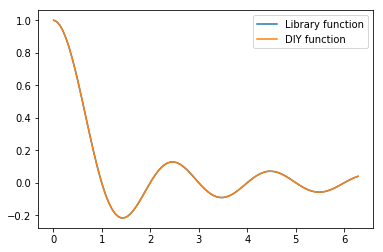

In [33]:
plt.plot(x, np.sinc(x), label='Library function')
plt.plot(x, np.sin(np.pi*x)/(np.pi*x), label='DIY function')
plt.legend()
pass